# Stoch Opt Project

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
# Fixing the seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 355kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.75MB/s]

tensor(5)


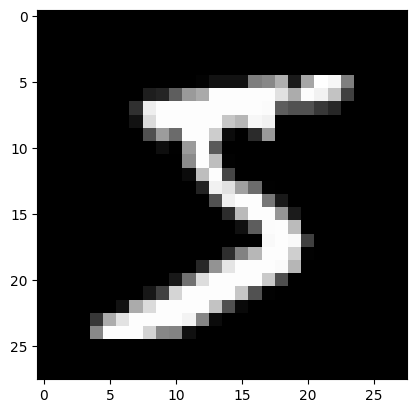

In [14]:
train_data, test_data = datasets.MNIST('data', train=True, download=True), datasets.MNIST('data', train=False, download=True)
x_train = train_data.data.view(-1, 28*28).float() / 255.0
y_train = train_data.targets
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model as a subclass of nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.w = nn.Parameter(torch.randn(input_dim, num_classes))

    def forward(self, x):
        return x @ self.w
    
def F_alpha_loss(model, x, target, alpha):
    logits = model(x) # (batch_size, num_classes)
    # we substract max_logits from exponential 
    # and then add them back for numerical stability
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log() # (batch_size, 1)

    labels = target.unsqueeze(1) # (batch_size, 1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1) # (batch_size, num_classes)
    subtract_term = (y_train * logits).sum(dim=1, keepdim=True) # (batch_size, 1)

    loss_data = torch.mean(log_sum_exp - subtract_term) # scalar

    alpha_term = 0.5 * alpha * torch.sum(model.w ** 2)

    return loss_data + alpha_term

In [31]:
def test(model, val_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = logits.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()

    return correct / total

In [37]:
from tqdm import tqdm

def train(model, train_loader, 
          val_loader,
          alpha, optimizer, optimizer_params,
          num_epochs=10, patience=3):
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), **optimizer_params)
    epoch_losses = []
    
    best_accuracy = 0
    epochs_without_improvement = 0

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            loss = F_alpha_loss(model, x_batch, y_batch, alpha)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        
        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        
        accuracy = test(model, val_loader)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss for alpha = {}'.format(alpha))
    plt.show()

    return model

In [43]:
from torch.utils.data import DataLoader, TensorDataset

def solve_bilevel(alpha_range,
                  train_data,
                  val_loader,
                  optimizer,
                  optimizer_params,
                  num_epochs=10,
                  batch_size=64):
    best_alpha = None
    best_acc = 0
    best_model = None

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))

    for alpha in alpha_range:
        print(f'Alpha: {alpha}')
        model = LogisticRegression(input_dim, num_classes)
        model = train(model, train_loader, val_loader, alpha, optimizer, optimizer_params, num_epochs)
        acc = test(model, val_loader)
        print(f'Accuracy: {acc}')

        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model

    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model

In [44]:
import ray

@ray.remote
def train_evaluate(alpha, train_data, val_loader, optimizer_cls, optimizer_params, num_epochs, batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))
    
    model = LogisticRegression(input_dim, num_classes)
    model = train(model, train_loader, alpha, optimizer_cls, optimizer_params, num_epochs)
    acc = test(model, val_loader)
    return alpha, acc, model

def parallel_solve_bilevel(alpha_range, train_data, val_loader, optimizer_cls, optimizer_params, num_epochs=10, batch_size=64):
    futures = [train_evaluate.remote(alpha, train_data, val_loader, optimizer_cls, optimizer_params, num_epochs, batch_size)
               for alpha in alpha_range]
    
    results = ray.get(futures)
    best_alpha, best_acc, best_model = None, 0, None
    for alpha, acc, model in results:
        print(f'Alpha: {alpha}, Accuracy: {acc}')
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model

    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model

In [45]:
from torch.optim import Optimizer

class Shampoo(Optimizer):
    def __init__(self, params, lr=0.1, eps=1e-4, momentum=0.9, compute_every=5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        defaults = dict(lr=lr, eps=eps, momentum=momentum, compute_every=compute_every)
        super(Shampoo, self).__init__(params, defaults)

    def _update_preconditioner(self, M, d_p, left=True):
        # Update the preconditioner
        if left:
            return M + d_p @ d_p.t()
        else:
            return M + d_p.t() @ d_p
        
    def _matrix_inv_power(self, M, power):
        eigen_values, eigen_vectors = torch.linalg.eigh(M)
        eigen_values = torch.clamp(eigen_values, min=1e-12)
        inv_power_diagonal = torch.diag(eigen_values.pow(-power))
        return eigen_vectors @ inv_power_diagonal @ eigen_vectors.t()

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            eps = group['eps']
            momentum = group['momentum']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['L'] = eps * torch.eye(p.shape[0], device=device)
                    state['R'] = eps * torch.eye(p.shape[1], device=device)
                    state['v'] = torch.zeros_like(p)

                
                state['v'] = momentum * state['v'] + (1-momentum) * d_p
                # Update the preconditioners
                self.state[p]['L'] = self._update_preconditioner(self.state[p]['L'], self.state[p]['v'], left=True)
                self.state[p]['R'] = self._update_preconditioner(self.state[p]['R'], self.state[p]['v'], left=False)

                # Compute the update
                if state['step'] % group['compute_every'] == 0:
                    state['L_inv_sqrt'] = self._matrix_inv_power(state['L'], 0.25)
                    state['R_inv_sqrt'] = self._matrix_inv_power(state['R'], 0.25)
                update_matrix = state['L_inv_sqrt'] @ state['v'] @ state['R_inv_sqrt']
                p.data.add_(update_matrix, alpha=-group['lr'])

                self.state[p]['step'] += 1

        return loss

In [46]:
# CONSTANTS
ALPHA_RANGE = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
NUM_EPOCHS = 1000
OPTIMIZER_PARAMS = {'lr': 0.1, 'eps': 1e-4, 'momentum': 0.9, 'compute_every': 5}
BATCH_SIZE = 1024
TRAIN_VAL_SPLIT_RATIO = 0.8
OPTIMIZER = Shampoo

784
Alpha: 1e-05


 24%|██▍       | 242/1000 [02:24<07:31,  1.68it/s]

Early stopping triggered at epoch 243


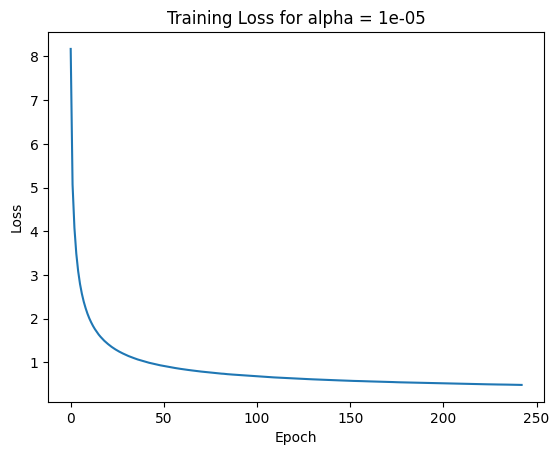

Accuracy: 0.8834166666666666
Alpha: 5e-05


 28%|██▊       | 281/1000 [02:48<07:11,  1.67it/s]

Early stopping triggered at epoch 282


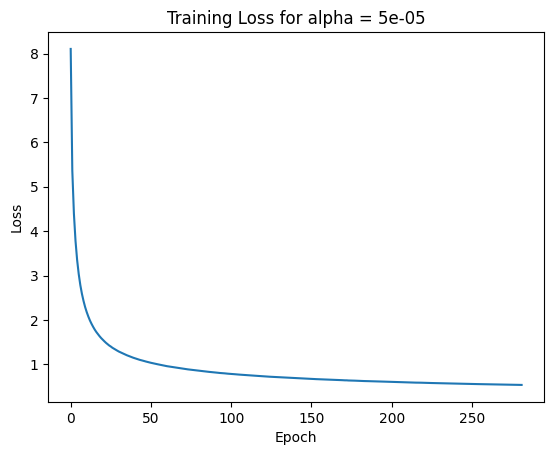

Accuracy: 0.88775
Alpha: 0.0001


 16%|█▌        | 159/1000 [01:35<08:27,  1.66it/s]

Early stopping triggered at epoch 160


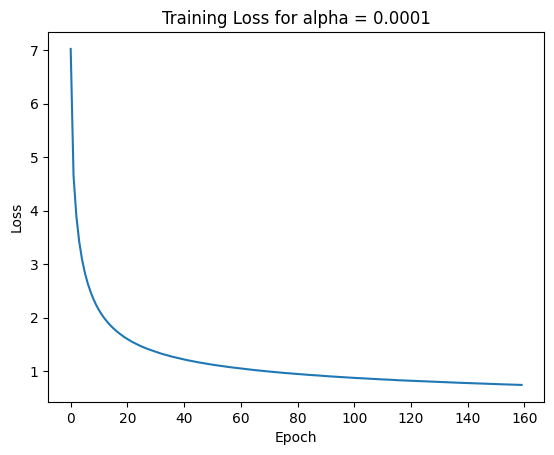

Accuracy: 0.8666666666666667
Alpha: 0.0005


 20%|██        | 205/1000 [02:02<07:55,  1.67it/s]

Early stopping triggered at epoch 206


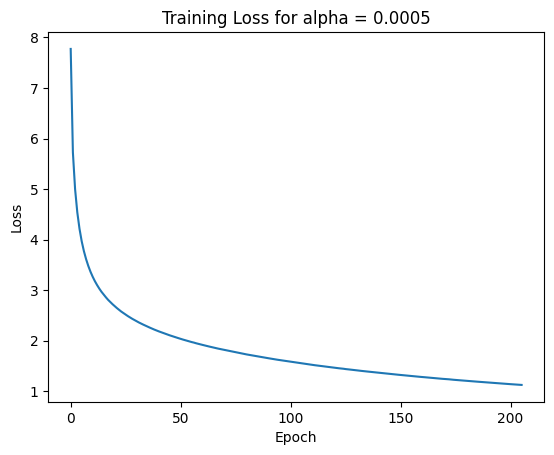

Accuracy: 0.8786666666666667
Alpha: 0.001


 27%|██▋       | 270/1000 [02:43<07:23,  1.65it/s]

Early stopping triggered at epoch 271


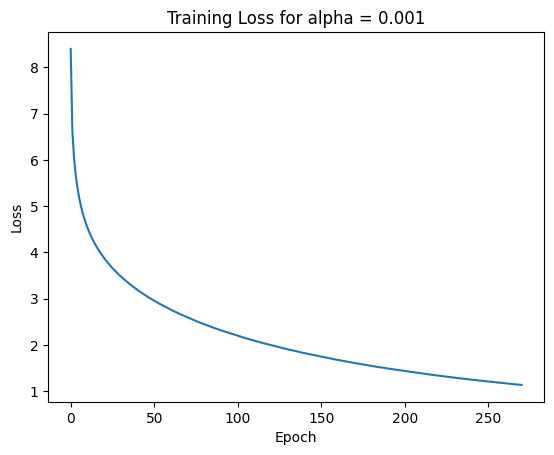

Accuracy: 0.8864166666666666
Alpha: 0.005


 39%|███▊      | 386/1000 [03:49<06:04,  1.68it/s]

Early stopping triggered at epoch 387


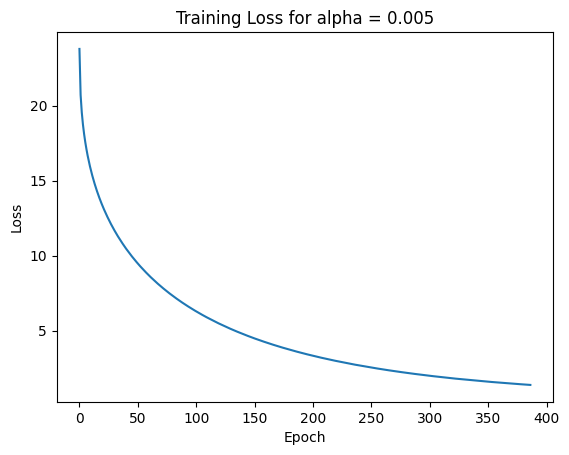

Accuracy: 0.8809166666666667
Alpha: 0.01


 33%|███▎      | 330/1000 [03:16<06:38,  1.68it/s]

Early stopping triggered at epoch 331


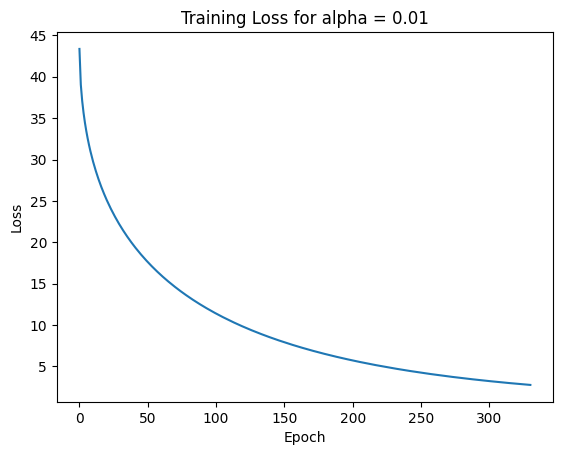

Accuracy: 0.84
Best alpha: 5e-05, Best accuracy: 0.88775


In [47]:
train_data = TensorDataset(x_train, y_train)
print(train_data.tensors[0].shape[1])
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
# make train data dataset again
train_data = TensorDataset(train_data.dataset.tensors[0], train_data.dataset.tensors[1])

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

best_alpha, best_acc, best_model = solve_bilevel(ALPHA_RANGE, train_data, val_loader, OPTIMIZER, OPTIMIZER_PARAMS, NUM_EPOCHS, BATCH_SIZE)

In [48]:
# Test the best model
x_test = test_data.data.view(-1, 28*28).float() / 255.0
y_test = test_data.targets
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_acc = test(best_model, test_loader)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.8927
